# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [6]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [7]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [11]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()
print(train_stats)
# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

               X1          X2          X3          X4          X5          X6  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.761922  673.550489  319.697068  176.926710    5.232899    3.503257   
std      0.105185   87.827178   44.765697   45.253475    1.751343    1.127654   
min      0.620000  514.500000  245.000000  110.250000    3.500000    2.000000   
25%      0.660000  612.500000  294.000000  122.500000    3.500000    2.000000   
50%      0.740000  686.000000  318.500000  220.500000    3.500000    3.000000   
75%      0.820000  759.500000  343.000000  220.500000    7.000000    5.000000   
max      0.980000  808.500000  416.500000  220.500000    7.000000    5.000000   

               X7          X8          Y1          Y2  
count  614.000000  614.000000  614.000000  614.000000  
mean     0.236401    2.747557   22.298870   24.596319  
std      0.133707    1.547440   10.182979    9.633433  
min      0.000000    0.000000    6.010000   10

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [12]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8256        dense_4[0][0]                    
____________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [14]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [15]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 234.4405 - y1_output_loss: 109.9961 - y2_output_loss: 122.6569 - y1_output_root_mean_squared_error: 10.5350 - y2_output_root_mean_squared_error: 11.1110 - val_loss: 65.9153 - val_y1_output_loss: 20.3153 - val_y2_output_loss: 45.8677 - val_y1_output_root_mean_squared_error: 4.4344 - val_y2_output_root_mean_squared_error: 6.8008
Epoch 2/500
614/614 [==============================] - 0s 155us/sample - loss: 31.0753 - y1_output_loss: 12.1225 - y2_output_loss: 18.8189 - y1_output_root_mean_squared_error: 3.4930 - y2_output_root_mean_squared_error: 4.3445 - val_loss: 40.7631 - val_y1_output_loss: 16.0308 - val_y2_output_loss: 25.6792 - val_y1_output_root_mean_squared_error: 3.8953 - val_y2_output_root_mean_squared_error: 5.0587
Epoch 3/500
614/614 [==============================] - 0s 157us/sample - loss: 26.1607 - y1_output_loss: 10.5585 - y2_output_loss: 15.5271 - y1_o

614/614 [==============================] - 0s 152us/sample - loss: 7.3701 - y1_output_loss: 2.5405 - y2_output_loss: 4.7702 - y1_output_root_mean_squared_error: 1.5998 - y2_output_root_mean_squared_error: 2.1933 - val_loss: 8.4075 - val_y1_output_loss: 3.3738 - val_y2_output_loss: 5.1849 - val_y1_output_root_mean_squared_error: 1.7709 - val_y2_output_root_mean_squared_error: 2.2959
Epoch 42/500
614/614 [==============================] - 0s 149us/sample - loss: 9.3667 - y1_output_loss: 3.1710 - y2_output_loss: 6.1124 - y1_output_root_mean_squared_error: 1.7881 - y2_output_root_mean_squared_error: 2.4838 - val_loss: 7.6087 - val_y1_output_loss: 2.8281 - val_y2_output_loss: 4.8201 - val_y1_output_root_mean_squared_error: 1.6299 - val_y2_output_root_mean_squared_error: 2.2253
Epoch 43/500
614/614 [==============================] - 0s 147us/sample - loss: 7.2201 - y1_output_loss: 2.4559 - y2_output_loss: 4.7872 - y1_output_root_mean_squared_error: 1.5658 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 149us/sample - loss: 6.3126 - y1_output_loss: 1.9723 - y2_output_loss: 4.2963 - y1_output_root_mean_squared_error: 1.4107 - y2_output_root_mean_squared_error: 2.0791 - val_loss: 7.9729 - val_y1_output_loss: 2.6030 - val_y2_output_loss: 5.8572 - val_y1_output_root_mean_squared_error: 1.5531 - val_y2_output_root_mean_squared_error: 2.3581
Epoch 63/500
614/614 [==============================] - 0s 142us/sample - loss: 6.6616 - y1_output_loss: 1.9923 - y2_output_loss: 4.6864 - y1_output_root_mean_squared_error: 1.4103 - y2_output_root_mean_squared_error: 2.1616 - val_loss: 6.3426 - val_y1_output_loss: 2.2836 - val_y2_output_loss: 4.2668 - val_y1_output_root_mean_squared_error: 1.4526 - val_y2_output_root_mean_squared_error: 2.0573
Epoch 64/500
614/614 [==============================] - 0s 148us/sample - loss: 5.6150 - y1_output_loss: 1.8080 - y2_output_loss: 3.7888 - y1_output_root_mean_squared_error: 1.3467 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 154us/sample - loss: 4.4762 - y1_output_loss: 1.3475 - y2_output_loss: 3.1256 - y1_output_root_mean_squared_error: 1.1642 - y2_output_root_mean_squared_error: 1.7666 - val_loss: 4.9719 - val_y1_output_loss: 1.3156 - val_y2_output_loss: 3.6240 - val_y1_output_root_mean_squared_error: 1.1108 - val_y2_output_root_mean_squared_error: 1.9334
Epoch 84/500
614/614 [==============================] - 0s 151us/sample - loss: 5.1720 - y1_output_loss: 1.4282 - y2_output_loss: 3.7147 - y1_output_root_mean_squared_error: 1.1965 - y2_output_root_mean_squared_error: 1.9340 - val_loss: 3.9613 - val_y1_output_loss: 1.4489 - val_y2_output_loss: 2.6991 - val_y1_output_root_mean_squared_error: 1.1496 - val_y2_output_root_mean_squared_error: 1.6247
Epoch 85/500
614/614 [==============================] - 0s 145us/sample - loss: 3.6880 - y1_output_loss: 0.9438 - y2_output_loss: 2.7245 - y1_output_root_mean_squared_error: 0.9755 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 152us/sample - loss: 2.5551 - y1_output_loss: 0.7520 - y2_output_loss: 1.7936 - y1_output_root_mean_squared_error: 0.8667 - y2_output_root_mean_squared_error: 1.3431 - val_loss: 2.9372 - val_y1_output_loss: 0.9810 - val_y2_output_loss: 1.9837 - val_y1_output_root_mean_squared_error: 0.9435 - val_y2_output_root_mean_squared_error: 1.4307
Epoch 105/500
614/614 [==============================] - 0s 154us/sample - loss: 2.7979 - y1_output_loss: 0.7189 - y2_output_loss: 2.1586 - y1_output_root_mean_squared_error: 0.8328 - y2_output_root_mean_squared_error: 1.4506 - val_loss: 10.2538 - val_y1_output_loss: 2.0479 - val_y2_output_loss: 8.7027 - val_y1_output_root_mean_squared_error: 1.4041 - val_y2_output_root_mean_squared_error: 2.8779
Epoch 106/500
614/614 [==============================] - 0s 175us/sample - loss: 2.6943 - y1_output_loss: 0.6618 - y2_output_loss: 2.0525 - y1_output_root_mean_squared_error: 0.8137 - y2_output_root_me

Epoch 145/500
614/614 [==============================] - 0s 156us/sample - loss: 1.4661 - y1_output_loss: 0.3383 - y2_output_loss: 1.1300 - y1_output_root_mean_squared_error: 0.5797 - y2_output_root_mean_squared_error: 1.0630 - val_loss: 1.9933 - val_y1_output_loss: 0.5482 - val_y2_output_loss: 1.5045 - val_y1_output_root_mean_squared_error: 0.7245 - val_y2_output_root_mean_squared_error: 1.2118
Epoch 146/500
614/614 [==============================] - 0s 142us/sample - loss: 3.7730 - y1_output_loss: 1.1071 - y2_output_loss: 2.6505 - y1_output_root_mean_squared_error: 1.0567 - y2_output_root_mean_squared_error: 1.6298 - val_loss: 3.7886 - val_y1_output_loss: 0.7850 - val_y2_output_loss: 3.0021 - val_y1_output_root_mean_squared_error: 0.8477 - val_y2_output_root_mean_squared_error: 1.7522
Epoch 147/500
614/614 [==============================] - 0s 149us/sample - loss: 1.5015 - y1_output_loss: 0.3329 - y2_output_loss: 1.1728 - y1_output_root_mean_squared_error: 0.5769 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 143us/sample - loss: 1.7919 - y1_output_loss: 0.4213 - y2_output_loss: 1.3673 - y1_output_root_mean_squared_error: 0.6509 - y2_output_root_mean_squared_error: 1.1697 - val_loss: 2.3219 - val_y1_output_loss: 0.4749 - val_y2_output_loss: 1.8585 - val_y1_output_root_mean_squared_error: 0.6692 - val_y2_output_root_mean_squared_error: 1.3690
Epoch 187/500
614/614 [==============================] - 0s 144us/sample - loss: 1.0329 - y1_output_loss: 0.2494 - y2_output_loss: 0.7765 - y1_output_root_mean_squared_error: 0.5011 - y2_output_root_mean_squared_error: 0.8842 - val_loss: 1.6262 - val_y1_output_loss: 0.3027 - val_y2_output_loss: 1.4328 - val_y1_output_root_mean_squared_error: 0.5330 - val_y2_output_root_mean_squared_error: 1.1585
Epoch 188/500
614/614 [==============================] - 0s 147us/sample - loss: 1.5655 - y1_output_loss: 0.3801 - y2_output_loss: 1.1774 - y1_output_root_mean_squared_error: 0.6191 - y2_output_root_mea

Epoch 227/500
614/614 [==============================] - 0s 156us/sample - loss: 1.1352 - y1_output_loss: 0.2533 - y2_output_loss: 0.8729 - y1_output_root_mean_squared_error: 0.5050 - y2_output_root_mean_squared_error: 0.9382 - val_loss: 1.5199 - val_y1_output_loss: 0.3458 - val_y2_output_loss: 1.2546 - val_y1_output_root_mean_squared_error: 0.5767 - val_y2_output_root_mean_squared_error: 1.0896
Epoch 228/500
614/614 [==============================] - 0s 159us/sample - loss: 1.0462 - y1_output_loss: 0.2037 - y2_output_loss: 0.8484 - y1_output_root_mean_squared_error: 0.4500 - y2_output_root_mean_squared_error: 0.9185 - val_loss: 2.7280 - val_y1_output_loss: 0.5751 - val_y2_output_loss: 2.3121 - val_y1_output_root_mean_squared_error: 0.7460 - val_y2_output_root_mean_squared_error: 1.4736
Epoch 229/500
614/614 [==============================] - 0s 147us/sample - loss: 0.9810 - y1_output_loss: 0.2394 - y2_output_loss: 0.7464 - y1_output_root_mean_squared_error: 0.4866 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 146us/sample - loss: 0.8787 - y1_output_loss: 0.1773 - y2_output_loss: 0.6975 - y1_output_root_mean_squared_error: 0.4219 - y2_output_root_mean_squared_error: 0.8371 - val_loss: 1.3050 - val_y1_output_loss: 0.2865 - val_y2_output_loss: 1.0464 - val_y1_output_root_mean_squared_error: 0.5332 - val_y2_output_root_mean_squared_error: 1.0103
Epoch 269/500
614/614 [==============================] - 0s 149us/sample - loss: 0.8889 - y1_output_loss: 0.2094 - y2_output_loss: 0.6775 - y1_output_root_mean_squared_error: 0.4559 - y2_output_root_mean_squared_error: 0.8253 - val_loss: 1.5073 - val_y1_output_loss: 0.3354 - val_y2_output_loss: 1.2170 - val_y1_output_root_mean_squared_error: 0.5702 - val_y2_output_root_mean_squared_error: 1.0872
Epoch 270/500
614/614 [==============================] - 0s 161us/sample - loss: 0.7791 - y1_output_loss: 0.1823 - y2_output_loss: 0.5953 - y1_output_root_mean_squared_error: 0.4284 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 162us/sample - loss: 0.5608 - y1_output_loss: 0.1369 - y2_output_loss: 0.4260 - y1_output_root_mean_squared_error: 0.3711 - y2_output_root_mean_squared_error: 0.6505 - val_loss: 3.9220 - val_y1_output_loss: 0.3212 - val_y2_output_loss: 3.5924 - val_y1_output_root_mean_squared_error: 0.5546 - val_y2_output_root_mean_squared_error: 1.9012
Epoch 310/500
614/614 [==============================] - 0s 165us/sample - loss: 0.7102 - y1_output_loss: 0.1729 - y2_output_loss: 0.5320 - y1_output_root_mean_squared_error: 0.4167 - y2_output_root_mean_squared_error: 0.7325 - val_loss: 1.2290 - val_y1_output_loss: 0.2510 - val_y2_output_loss: 1.0039 - val_y1_output_root_mean_squared_error: 0.4935 - val_y2_output_root_mean_squared_error: 0.9927
Epoch 311/500
614/614 [==============================] - 0s 159us/sample - loss: 0.6277 - y1_output_loss: 0.1425 - y2_output_loss: 0.4825 - y1_output_root_mean_squared_error: 0.3776 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 142us/sample - loss: 1.1049 - y1_output_loss: 0.2043 - y2_output_loss: 0.8920 - y1_output_root_mean_squared_error: 0.4531 - y2_output_root_mean_squared_error: 0.9485 - val_loss: 1.1740 - val_y1_output_loss: 0.2497 - val_y2_output_loss: 0.9471 - val_y1_output_root_mean_squared_error: 0.4940 - val_y2_output_root_mean_squared_error: 0.9643
Epoch 351/500
614/614 [==============================] - 0s 145us/sample - loss: 0.7067 - y1_output_loss: 0.1842 - y2_output_loss: 0.5213 - y1_output_root_mean_squared_error: 0.4296 - y2_output_root_mean_squared_error: 0.7226 - val_loss: 1.3463 - val_y1_output_loss: 0.2950 - val_y2_output_loss: 1.0997 - val_y1_output_root_mean_squared_error: 0.5371 - val_y2_output_root_mean_squared_error: 1.0285
Epoch 352/500
614/614 [==============================] - 0s 155us/sample - loss: 0.6173 - y1_output_loss: 0.1628 - y2_output_loss: 0.4583 - y1_output_root_mean_squared_error: 0.4044 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 155us/sample - loss: 0.6521 - y1_output_loss: 0.1674 - y2_output_loss: 0.4815 - y1_output_root_mean_squared_error: 0.4099 - y2_output_root_mean_squared_error: 0.6957 - val_loss: 1.0380 - val_y1_output_loss: 0.2343 - val_y2_output_loss: 0.8226 - val_y1_output_root_mean_squared_error: 0.4790 - val_y2_output_root_mean_squared_error: 0.8992
Epoch 392/500
614/614 [==============================] - 0s 142us/sample - loss: 0.4748 - y1_output_loss: 0.1265 - y2_output_loss: 0.3626 - y1_output_root_mean_squared_error: 0.3559 - y2_output_root_mean_squared_error: 0.5900 - val_loss: 2.6127 - val_y1_output_loss: 0.2842 - val_y2_output_loss: 2.2830 - val_y1_output_root_mean_squared_error: 0.5317 - val_y2_output_root_mean_squared_error: 1.5264
Epoch 393/500
614/614 [==============================] - 0s 145us/sample - loss: 0.5114 - y1_output_loss: 0.1157 - y2_output_loss: 0.3972 - y1_output_root_mean_squared_error: 0.3405 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 151us/sample - loss: 0.4378 - y1_output_loss: 0.1338 - y2_output_loss: 0.3035 - y1_output_root_mean_squared_error: 0.3642 - y2_output_root_mean_squared_error: 0.5525 - val_loss: 1.1338 - val_y1_output_loss: 0.3092 - val_y2_output_loss: 0.8347 - val_y1_output_root_mean_squared_error: 0.5483 - val_y2_output_root_mean_squared_error: 0.9128
Epoch 433/500
614/614 [==============================] - 0s 153us/sample - loss: 0.4465 - y1_output_loss: 0.1239 - y2_output_loss: 0.3211 - y1_output_root_mean_squared_error: 0.3520 - y2_output_root_mean_squared_error: 0.5680 - val_loss: 1.2940 - val_y1_output_loss: 0.2643 - val_y2_output_loss: 1.0306 - val_y1_output_root_mean_squared_error: 0.5133 - val_y2_output_root_mean_squared_error: 1.0152
Epoch 434/500
614/614 [==============================] - 0s 154us/sample - loss: 0.4259 - y1_output_loss: 0.1147 - y2_output_loss: 0.3121 - y1_output_root_mean_squared_error: 0.3391 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 157us/sample - loss: 0.4263 - y1_output_loss: 0.1013 - y2_output_loss: 0.3270 - y1_output_root_mean_squared_error: 0.3190 - y2_output_root_mean_squared_error: 0.5697 - val_loss: 1.7550 - val_y1_output_loss: 0.2435 - val_y2_output_loss: 1.5496 - val_y1_output_root_mean_squared_error: 0.4979 - val_y2_output_root_mean_squared_error: 1.2276
Epoch 474/500
614/614 [==============================] - 0s 143us/sample - loss: 0.4594 - y1_output_loss: 0.1271 - y2_output_loss: 0.3318 - y1_output_root_mean_squared_error: 0.3548 - y2_output_root_mean_squared_error: 0.5775 - val_loss: 1.0152 - val_y1_output_loss: 0.2307 - val_y2_output_loss: 0.8009 - val_y1_output_root_mean_squared_error: 0.4795 - val_y2_output_root_mean_squared_error: 0.8862
Epoch 475/500
614/614 [==============================] - 0s 143us/sample - loss: 0.3010 - y1_output_loss: 0.0940 - y2_output_loss: 0.2056 - y1_output_root_mean_squared_error: 0.3077 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [16]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 39us/sample - loss: 1.0365 - y1_output_loss: 0.2133 - y2_output_loss: 0.8095 - y1_output_root_mean_squared_error: 0.4638 - y2_output_root_mean_squared_error: 0.9063
Loss = 1.0364781850344176, Y1_loss = 0.21332645416259766, Y1_mse = 0.46379297971725464, Y2_loss = 0.8094976544380188, Y2_mse = 0.906296968460083


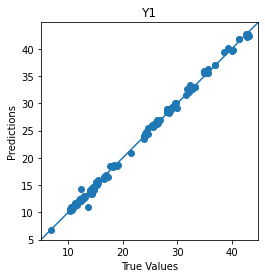

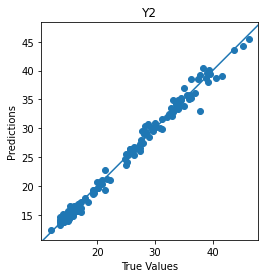

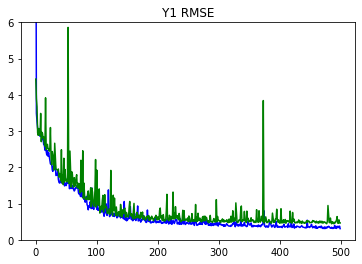

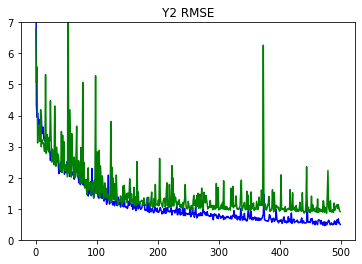

In [17]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)